In [ ]:
import pandas as pd
import json

#Load and Merge Data
df_locations = pd.read_csv(r"C:\Users\kusha\OneDrive\Desktop\enviro-scan\data\specific_locations_cleaned.csv")
df_pollution = pd.read_csv(r"C:\Users\kusha\OneDrive\Desktop\enviro-scan\data\pollution_data.csv")
df = pd.merge(df_pollution, df_locations, left_on='location_id', right_on='id', how='left')

# Extract Coordinates from the 'coordinates' Column
# The coordinates are stored as string text that looks like a dictionary.

def extract_coords(coord_str):
    try:
        valid_json_str = coord_str.replace("'", '"')
        coord_dict = json.loads(valid_json_str)
        return coord_dict.get('latitude'), coord_dict.get('longitude')
    except (TypeError, json.JSONDecodeError):
        return None, None

# Apply the function to the 'coordinates' column
df['latitude'], df['longitude'] = zip(*df['coordinates'].apply(extract_coords))


# Clean Up the DataFrame
# Drop the messy coordinate column and other unnecessary columns
columns_to_drop = [
    'city', 'lat', 'lon', 'id', 'locality', 'timezone', 'owner', 'provider', 
    'isMobile', 'isMonitor', 'instruments', 'sensors', 'coordinates', 
    'licenses', 'bounds', 'distance', 'datetimeFirst', 'datetimeLast'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# drop any rows where the coordinates could not be extracted
df.dropna(subset=['latitude', 'longitude'], inplace=True)


#Handle Missing Pollutant Values (Methodical Imputation)
pollutant_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'co', 'aqi']
for col in pollutant_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val) # This avoids the FutureWarning

print("--- Cleaned and Processed Data ---")
print(df.head())
df.info()

--- Cleaned and Processed Data ---
   location_id  pm2_5   pm10   no2   so2     o3      co  aqi  \
0         12.0  10.59  17.08  3.80  1.57  68.01  179.31    2   
1         13.0  14.19  29.80  6.90  1.33  64.57  179.12    2   
2         15.0  15.48  30.95  7.10  1.83  67.35  183.53    2   
3         16.0  14.33  30.10  8.64  1.49  61.21  198.46    2   
4         17.0  15.48  30.95  7.10  1.83  67.35  183.53    2   

                                           name  \
0                          SPARTAN - IIT Kanpur   
1  Delhi Technological University, Delhi - CPCB   
2                                   IGI Airport   
3                                   Civil Lines   
4                       R K Puram, Delhi - DPCC   

                                    country   latitude  longitude  
0  {'id': 9, 'code': 'IN', 'name': 'India'}  26.519000  80.233000  
1  {'id': 9, 'code': 'IN', 'name': 'India'}  28.744000  77.120000  
2  {'id': 9, 'code': 'IN', 'name': 'India'}  28.560000  77.094000  
3

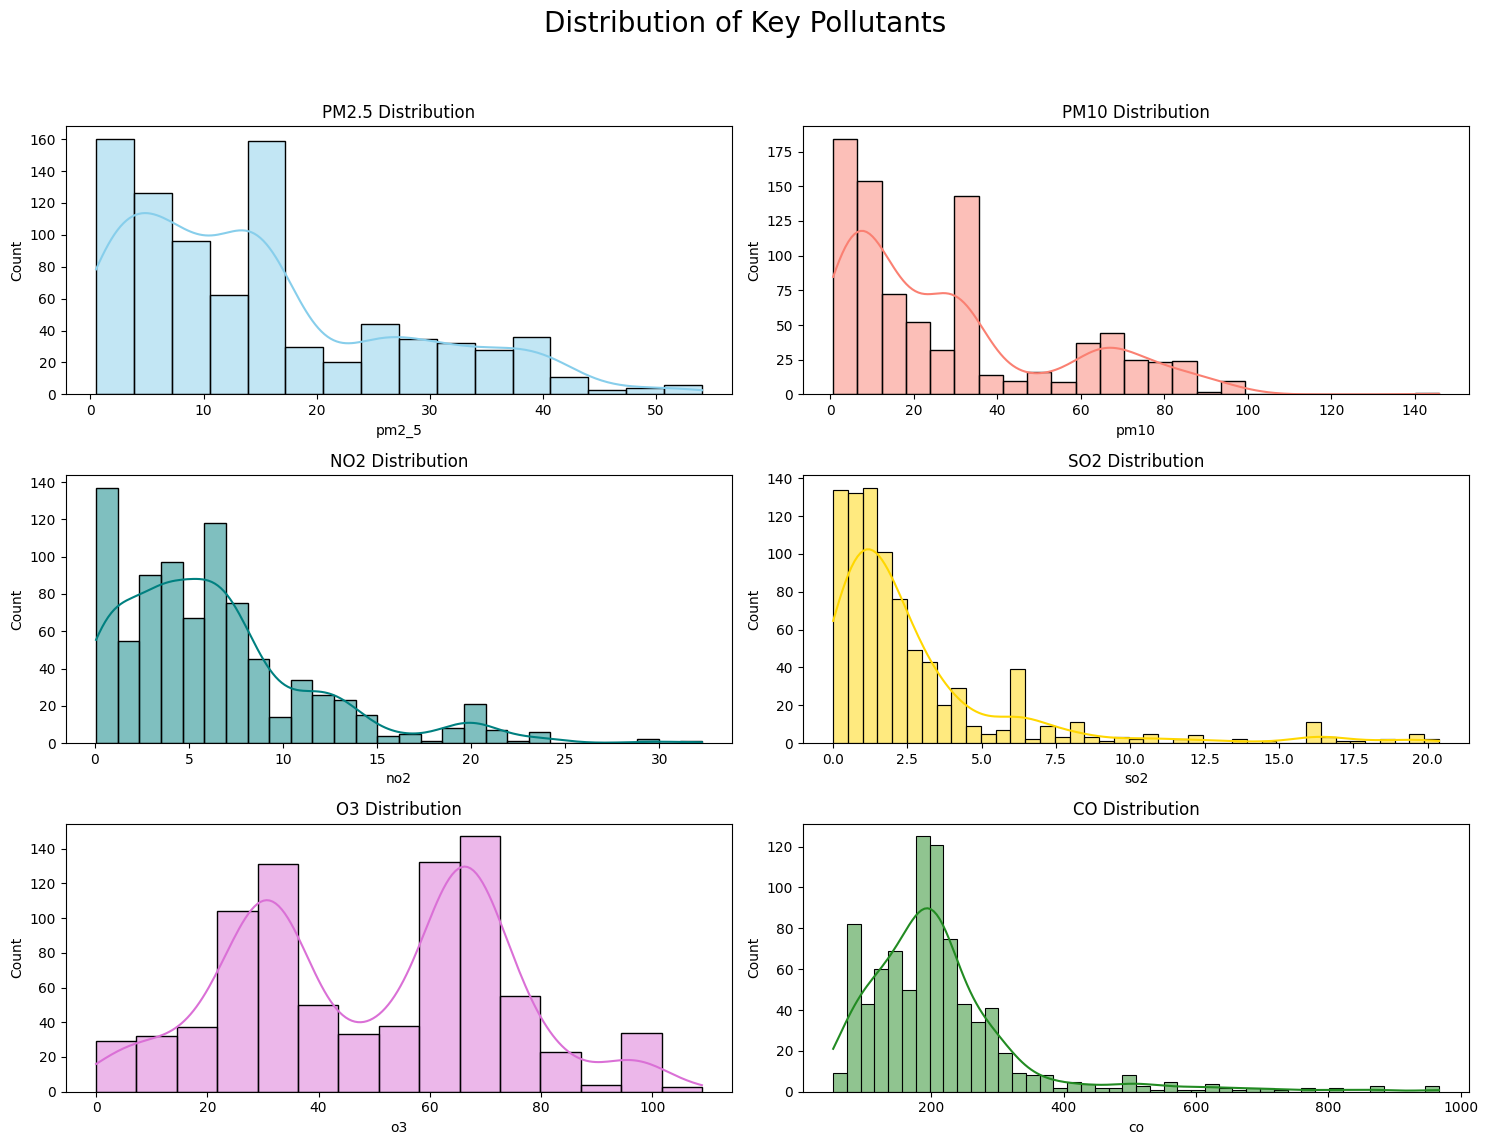

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Analyzing Pollutant Distributions
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Distribution of Key Pollutants', fontsize=20)

sns.histplot(df['pm2_5'], kde=True, ax=axes[0, 0], color='skyblue').set_title('PM2.5 Distribution')
sns.histplot(df['pm10'], kde=True, ax=axes[0, 1], color='salmon').set_title('PM10 Distribution')
sns.histplot(df['no2'], kde=True, ax=axes[1, 0], color='teal').set_title('NO2 Distribution')
sns.histplot(df['so2'], kde=True, ax=axes[1, 1], color='gold').set_title('SO2 Distribution')
sns.histplot(df['o3'], kde=True, ax=axes[2, 0], color='orchid').set_title('O3 Distribution')
sns.histplot(df['co'], kde=True, ax=axes[2, 1], color='forestgreen').set_title('CO Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

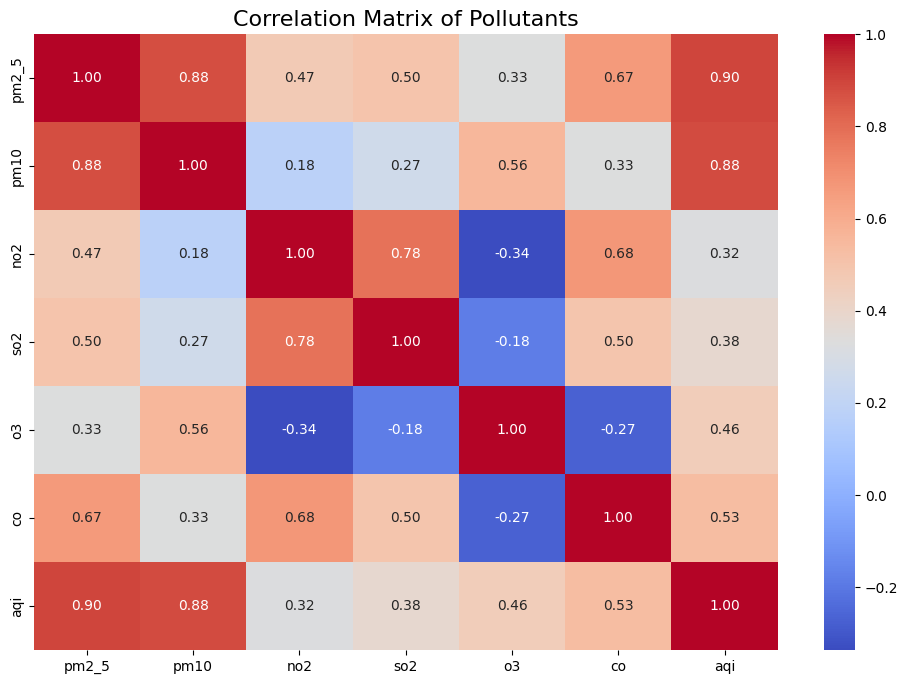

In [ ]:
import seaborn as sns

#Correlation Heatmap
plt.figure(figsize=(12, 8))
# Select only the numerical columns for correlation
corr_matrix = df[pollutant_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Pollutants', fontsize=16)
plt.show()

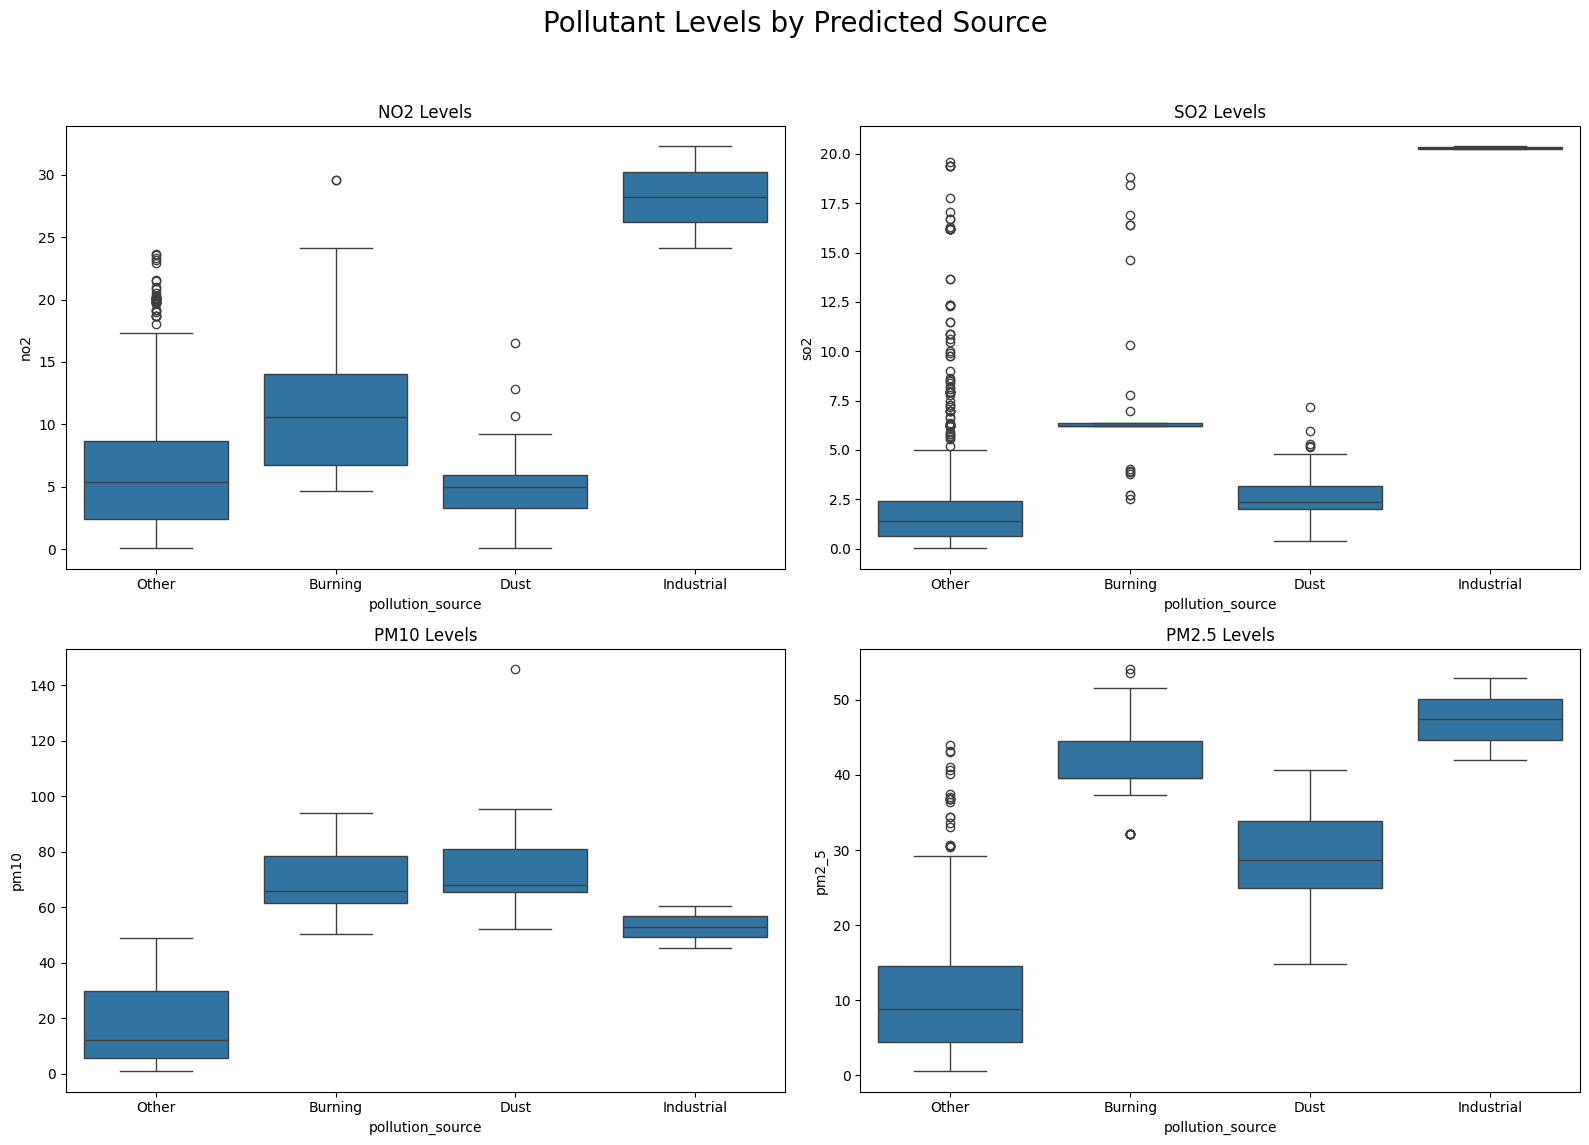

In [ ]:
# Labeling and Visualization by Source

def label_pollution_source(row):
    if row['no2'] > 40: return 'Vehicular' # 0-40 , 40-1000
    if row['so2'] > 20: return 'Industrial'
    if row['pm10'] > 50:
        if (row['pm2_5'] / (row['pm10'] + 1e-6)) > 0.5: return 'Burning'
        else: return 'Dust'
    return 'Other'

df['pollution_source'] = df.apply(label_pollution_source, axis=1)

# visualizing the relationship with box plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pollutant Levels by Predicted Source', fontsize=20)

sns.boxplot(data=df, x='pollution_source', y='no2', ax=axes[0, 0]).set_title('NO2 Levels')
sns.boxplot(data=df, x='pollution_source', y='so2', ax=axes[0, 1]).set_title('SO2 Levels')
sns.boxplot(data=df, x='pollution_source', y='pm10', ax=axes[1, 0]).set_title('PM10 Levels')
sns.boxplot(data=df, x='pollution_source', y='pm2_5', ax=axes[1, 1]).set_title('PM2.5 Levels')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib


# The 'country' column is a dictionary. Let's extract just the country code.
# The .str accessor safely handles the dictionary-like strings
df['country_code'] = df['country'].str.get('code')

# Fill the one missing name with Unknown
df['name'].fillna('Unknown', inplace=True)

# Select the final features for the model.
features_to_use = [
    'pm2_5', 'pm10', 'no2', 'so2', 'o3', 'co', 'aqi', 'latitude', 'longitude'
]
target_variable = 'pollution_source'

X = df[features_to_use]
y = df[target_variable]

print("--- Final Features Selected ---")
print(X.head())

#Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,      # Use 25% of the data for testing
    random_state=42,     # Ensures results are reproducible
    stratify=y           # Important for imbalanced classes
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

#Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Random Forest Model
print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)
print("Model training complete.")


# Evaluate the Model
print("\n--- Model Performance on Test Data ---")
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


# We need to save the scaler
joblib.dump(model, 'pollution_source_model.joblib')
joblib.dump(scaler, 'data_scaler.joblib')

print("\nModel and scaler have been saved to 'pollution_source_model.joblib' and 'data_scaler.joblib'")

C:\Users\kusha\AppData\Local\Temp\ipykernel_1576\3467888058.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['name'].fillna('Unknown', inplace=True)


--- Final Features Selected ---
   pm2_5   pm10   no2   so2     o3      co  aqi   latitude  longitude
0  10.59  17.08  3.80  1.57  68.01  179.31    2  26.519000  80.233000
1  14.19  29.80  6.90  1.33  64.57  179.12    2  28.744000  77.120000
2  15.48  30.95  7.10  1.83  67.35  183.53    2  28.560000  77.094000
3  14.33  30.10  8.64  1.49  61.21  198.46    2  28.678700  77.226200
4  15.48  30.95  7.10  1.83  67.35  183.53    2  28.563262  77.186937

Training set size: 639 samples
Testing set size: 213 samples

Training Random Forest Classifier...
Model training complete.

--- Model Performance on Test Data ---
              precision    recall  f1-score   support

     Burning       0.85      1.00      0.92        11
        Dust       1.00      0.94      0.97        35
       Other       1.00      1.00      1.00       167

    accuracy                           0.99       213
   macro avg       0.95      0.98      0.96       213
weighted avg       0.99      0.99      0.99       213


M